<a href="https://colab.research.google.com/github/jillrosow/WebDev/blob/master/USPTO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
# imports 
import pandas as pd
import numpy as np 
import glob
import os
from google.colab import drive 
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import logging
!pip install simpletransformers
from simpletransformers.classification import (
    MultiLabelClassificationModel, ClassificationArgs
)
from ast import literal_eval

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 215kB 4.7MB/s 
     |████████████████████████████████| 778kB 13.1MB/s 
     |████████████████████████████████| 3.0MB 16.5MB/s 
     |████████████████████████████████| 71kB 9.6MB/s 
     |████████████████████████████████| 1.4MB 59.5MB/s 
     |████████████████████████████████| 7.2MB 54.6MB/s 
     |████████████████████████████████| 317kB 55.8MB/s 
     |████████████████████████████████| 1.1MB 48.7MB/s 
     |████████████████████████████████| 890kB 59.2MB/s 
     |████████████████████████████████| 102kB 12.8MB/s 
     |████████████████████████████████| 163kB 59.4MB/s 
     |████████████████████████████████| 122kB 66.8MB/s 
     |████████████████████████████████| 102kB 14.1MB/s 
     |████████████████████████████████| 112kB 60.3MB/s 
     |████████████████████████████████| 4.4MB 56.3MB/s 
     |████████████████████████████████| 71kB 10.5MB/

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
# only used for google colab
# drive.mount('/content/gdrive')
# %cd /content/gdrive/My\ Drive/LUCIDWORKS/notebook

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/LUCIDWORKS/notebook


# Preprocessing and Visualizations

### 1. Import data

In [ ]:
# import the data
path = glob.glob("../data/*.csv")
data = pd.read_csv(path[0])
data.head()

,Unnamed: 0,patent_id,text,uuid,section_id,subsection_id,group_id,subgroup_id,category,sequence
0,773712,7985557,['1. A method for performing a diagnostic assa...,kjpmj18jrn46k7975bzfmkyk2,G,G01,G01N,G01N33/532,inventional,5
1,128718,7885754,"['1. A vehicle, comprising: an engine comprisi...",bdm72tuhjgh15tffo4vqnf62i,Y,Y02,Y02T,Y02T10/44,additional,4
2,1312296,8077567,['1. A recording and reproducing apparatus com...,lf6g1evkz0f53dg6r6ofhig0g,G,G11,G11B,G11B2220/60,additional,8
3,207236,7898066,['1. A semiconductor device comprising: a subs...,l8tdceyp9kv06ewlpm1ms97ez,H,H01,H01L,H01L2924/16195,additional,42
4,1260457,8065158,['1. A method of decoding an audio signal by a...,b5qifaz2g55wq8boh6rmo1muc,G,G10,G10L,G10L19/00,additional,10


### 2. Functions for cleaning data 
- **clean_text**: Converts text to lowercase, removes all characters except letters and strips whitespace
- **clean_sections**: After grouping the data by id and adding all the section codes together, this is used to grab the unique class labels and put them in list form 
- **remove_stopwords**: Removes stop words found in nltk english list plus 20 custom words found to be the most popular in the claim text.

In [ ]:
# data cleaning (lower case, remove numbers and punctuation)
def clean_text(text):
  # convert text to lowercase 
  text = text.lower() 
  # remove everything except alphabets 
  text = re.sub("[^a-z]"," ",text) 
  # remove whitespaces 
  text = ' '.join(text.split()) 
  return text

def clean_sections(text):
    return list(set(text))

def remove_stopwords(text):
    return ' '.join([w for w in text.split() if not w in stops])


###3. Functions for claim text word visualizations
- **freq_words**: Can be used to count word frequencies from a list (useful if tokenized already)
- **get_top_n_words**: Used to find top "n" unigrams in a corpus of text 
- **get_top_n_bigram**: Used to find top "n" bigrams in a corpus of text 
- **get_top_n_trigram**: Used to find top "n" trigrams ina  corpus of text

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def freq_words(x, terms = 20): 
    all_words = ' '.join(str(e) for e in x)
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 

    # selecting top 20 most frequent words 
    return words_df.nlargest(columns="count", n = terms) 

# unigrams
def get_top_n_words(corpus, n=None, stop=False):
    if stop:
        vec = CountVectorizer(stop_words = stops).fit(corpus)
    else:
        vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# bigrams
def get_top_n_bigram(corpus, n=None, stop=False):
    if stop:
        vec = CountVectorizer(ngram_range=(2, 2), stop_words=stops).fit(corpus)
    else:
        vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# trigrams 
def get_top_n_trigram(corpus, n=None, stop=False):
    if stop:
        vec = CountVectorizer(ngram_range=(3, 3), stop_words=stops).fit(corpus)
    else:
        vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

###4. Grabbing patent_id, text, and section_id as these are the only relevant variables. 
- Text is cleaned in this phase
- Section cleaning and stop word removal is not performed until I get a better understanding of the raw data

In [ ]:
# Grab only the text and labels (section_id)
df_pr = data.loc[:,['patent_id', 'text', 'section_id']]

# clean the text 
df_pr['text_clean'] = df_pr.text.apply(lambda x: clean_text(x))


###5. Visualizations of unigrams, bigrams, and trigrams
- top 20 unigrams per section are visualized as well
- stop word corpus additions are decided after unigram visualization



Unigram Visualizations

---



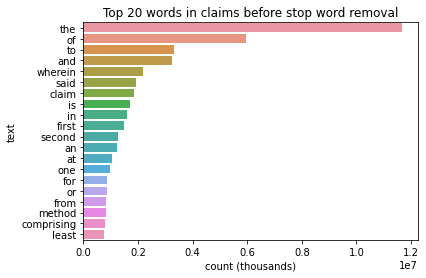

In [ ]:
# top 20 words before stop word removal 
#plt.figure(figsize=(12,15)) 
common_words = get_top_n_words(df_pr['text_clean'], 20)
df1 = pd.DataFrame(common_words, columns = ['claimText' , 'count'])

ax = sns.barplot(data=df1, x= "count", y = "claimText") 
ax.set(ylabel = 'text', xlabel="count", title="Top 20 words in claims before stop word removal") 
plt.show()

In [ ]:
common_words = get_top_n_words(df_pr['text_clean'], 20)
df1 = pd.DataFrame(common_words, columns = ['claimText' , 'count'])

The top 20 words seem to all be filler or stop words. These words aren't associated with claim text specfically, so I remove them all to aim for more descriptive text.

In [ ]:
# add the top 20 most common words from the claims data to list of standard stopwords 
stops = stopwords.words('english')
top20 = df1.claimText.values
claim_stops = [word for word in top20 if not word in stops]
#claim_stops = [word for word in top20["word"] if not word in stops]
stops += claim_stops

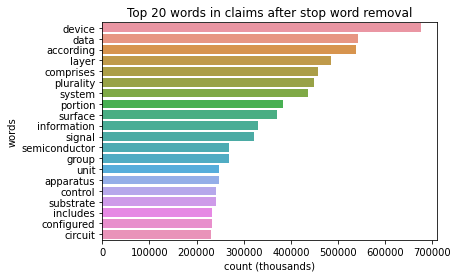

In [ ]:
# top 20 words after stop word removal 
common_words = get_top_n_words(df_pr.text_clean, 20, True)
df2 = pd.DataFrame(common_words, columns=['claimText', 'count'])

ax = sns.barplot(data=df2, x= "count", y = "claimText") 
ax.set(ylabel = 'words', xlabel="count", title="Top 20 words in claims after stop word removal") 
plt.show()

With the stop words removed, the top 20 list is much more detailed, specific, and claim oriented.

Bigram Visualizations

---

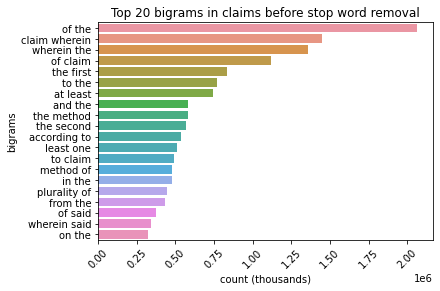

In [ ]:
# top 20 bigrams before stop words removal 
common_words = get_top_n_bigram(df_pr.text_clean, 20)
df3 = pd.DataFrame(common_words, columns=['claimText', 'count'])

# need to rotate x ticks
ax = sns.barplot(data=df3, x= "count", y = "claimText") 
ax.set(ylabel = 'bigrams', xlabel="count", title="Top 20 bigrams in claims before stop word removal") 
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.show()

Similarly to the unigram chart, the bigrams don't relay much information about the text as a whole. 

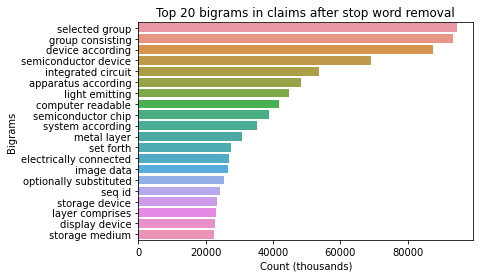

In [ ]:
# top 20 bigrams after stop word removal 
common_words = get_top_n_bigram(df_pr.text_clean, 20, True)
df4 = pd.DataFrame(common_words, columns=['claimText', 'count'])

ax = sns.barplot(data=df4, x= "count", y = "claimText") 
ax.set(ylabel = 'Bigrams', xlabel="count", title="Top 20 bigrams in claims after stop word removal") 
plt.show()

With stop words omitted, one can begin to imagine categories for these bigrams.

Trigram Visualizations

---

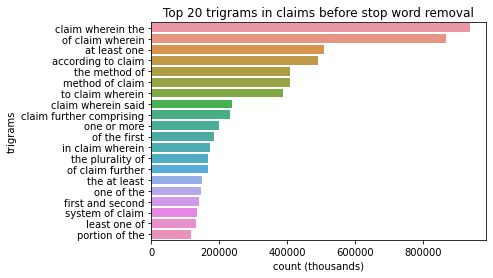

In [ ]:
# top 20 trigrams before stop word removal 
common_words = get_top_n_trigram(df_pr.text_clean, 20)
df5 = pd.DataFrame(common_words, columns=['claimText', 'count'])

ax = sns.barplot(data=df5, x= "count", y = "claimText") 
ax.set(ylabel = 'trigrams', xlabel="count", title="Top 20 trigrams in claims before stop word removal") 
plt.show()

Even when examining 3 words at a time, without stop word removal the trigrams do not hold categorical value.

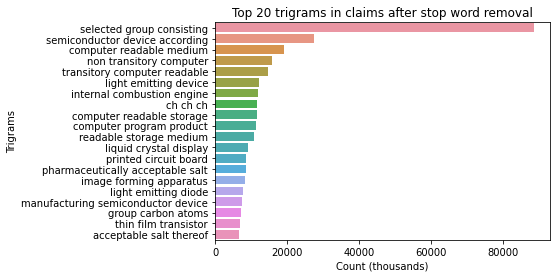

In [ ]:
# top 20 trigrams after stop word removal 
common_words = get_top_n_trigram(df_pr.text_clean, 20, True)
df6 = pd.DataFrame(common_words, columns=['claimText', 'count'])

ax = sns.barplot(data=df6, x= "count", y = "claimText") 
ax.set(ylabel = 'Trigrams', xlabel="count", title="Top 20 trigrams in claims after stop word removal") 
plt.show()

Stop words removal seems consistently useful, so I will implement it across the entire corpus.

In [ ]:
df_pr['text_ns'] = df_pr.text_clean.apply(lambda x: remove_stopwords(x))

I'm now interested in the top 20 words in each section after stop word removal. Can I get a sense of the category just from the top 20 words?

In [ ]:
# looking at each sections most popular words
df_bi = df_pr[['text_clean', 'section_id']]
section_words = df_bi.groupby("section_id")['text_clean'].apply(lambda x: get_top_n_words(x, 20, True))

# for graph labeling purposes
labels = {x:y for x,y in zip(range(10),section_words.index.values)}
labels

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'Y'}

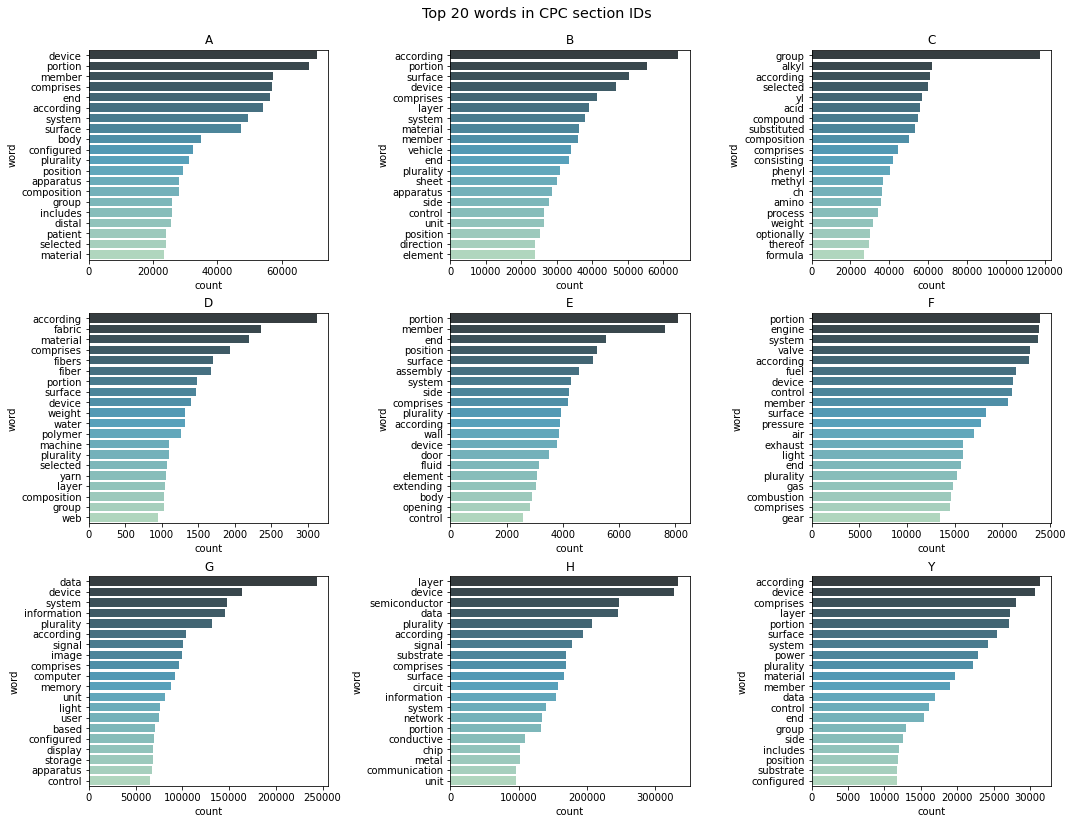

In [ ]:
_ = plt.subplots(figsize=(15, 12))
st = _[0].suptitle("Top 20 words in CPC section IDs", fontsize='x-large')

for i in range(9):
    df = pd.DataFrame(section_words[i], columns=['word', 'count'])
    _ = plt.subplot(3,3,i+1)
    _ = sns.barplot(data=df, x= "count", y = "word", palette='GnBu_d') 
    _.set_title(labels[i])

# formatting
_ = plt.tight_layout()
# shift subplots down:
st.set_y(0.95)
_ = plt.subplots_adjust(top=0.9)
plt.show()

Wow! The top 20 words (after stop word removal) in each CPC category give us a lot of information about that category. 

Just by looking at these charts, I can guess:
- class A probably deals with humans (clues: human, distal, patient)
- class B probably deals with transportation (clues: vehicle, direction) 
- class C probably deals with chemistry (clues: alkyl, phenyl, methyl, etc)
- class D probably deals with materials (clues: material, fibers, polymer, yarn)
- class E probably deals with construction (clues: assembly, wall, door)
- class F likely deals with mechanical engineering (clues: pressure, gas, combustion, valve, gear)
- class G likely deals with physics or computers (clues: light, unit, apparatus, computer)
- class H likely deals with electricity (clues: conductive, circuit, semiconductor, unit)
- class Y is harder to guess, with what looks like a mix or catchall of all the categories 

After confirming with the CPC Schema from USPTO, my guesses aren't far off. The data preprocessing must be doing a good job.

###6. Class distribution visualizations
- Data is finally grouped by patent_id to find multi label information 
- Label data can now be cleaned to reflect patent multi labels
- Number of claims in each label is graphed 
- Distribution of claims belonging to multiple CPC codes is shown 

In [ ]:
# group by patent id to see the other labels they were given 
df_gr = df_pr.groupby('patent_id')[['section_id', 'text_ns']].sum()
df_gr.reset_index(inplace=True)
df_gr.drop('patent_id', inplace=True, axis=1)

# clean section data 
df_gr['section_clean'] = df_gr['section_id'].apply(lambda x: clean_sections(x))

df_clean = df_gr.loc[:, ['text_ns', 'section_clean']]
df_clean.columns = ['text', 'label']
df_clean.head(3)

,text,label
0,sports lifting aid main body configured positi...,[A]
1,patient care apparatus adapted use patient pat...,[A]
2,patient support apparatus use detachable patie...,[A]


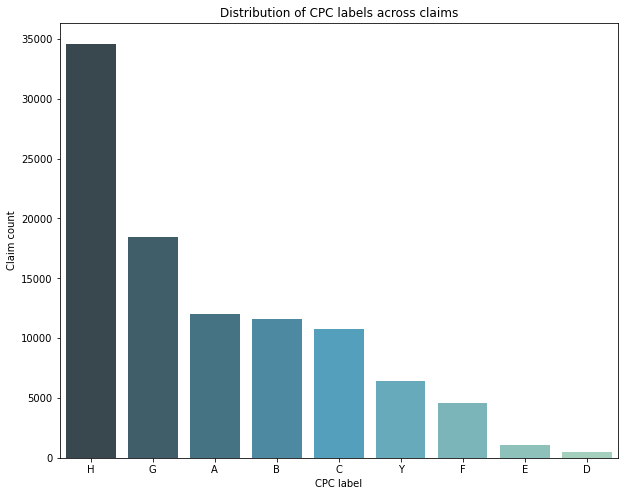

In [ ]:

# distribution of the classes 
sections = nltk.FreqDist(df_pr.section_id) 

# create dataframe
sections_df = pd.DataFrame({'Section': list(sections.keys()), 
                              'Count': list(sections.values())})
# in order 
s = sections_df.nlargest(columns="Count", n = 9) 

plt.figure(figsize=(10,8)) 
ax = sns.barplot(data=s, x="Section", y = 'Count', palette='GnBu_d') 
ax.set(xlabel = 'CPC label', ylabel='Claim count', title='Distribution of CPC labels across claims') 
plt.show()

The most represented category is H (Electricity), with G (Physics) coming in second. The least data comes from D (Textiles and Paper). This imbalance could be due to a small sample size covering a limited number of years, or it could be representative of the technology boom. 

Adding data from other years could help the class imbalance (increase data size). Alternatively, resampling techniques such as undersampling the majority classes or oversampling the minority classes could be done to artificially reduce skew. 

For the scope of this project, class imbalance is mitigated by choosing appropriate evaluation metrics such as micro averaging the f1 score.

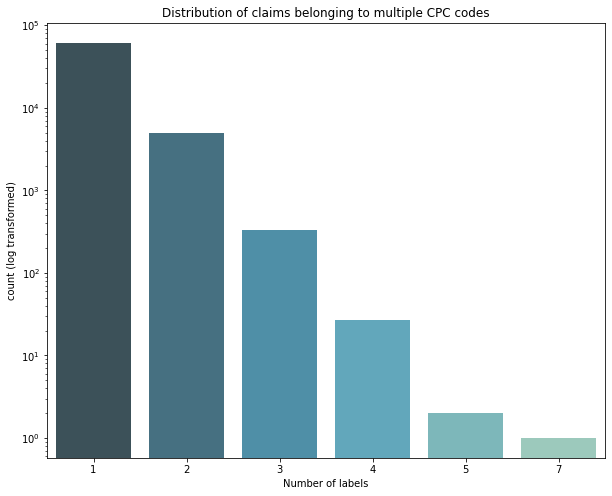

In [ ]:
df_gr['section_count'] = df_gr['section_clean'].str.len()

plt.figure(figsize=(10,8)) 
ax = sns.countplot(df_gr.section_count, palette='GnBu_d')
ax.set(xlabel = 'Number of labels', yscale='log', ylabel='count (log transformed)', title='Distribution of claims belonging to multiple CPC codes') 
plt.show()

- Log transformation to understand trend 

- Most claims have no more than 4 labels


#BASELINE MODELS

####1. Binary relevance problem transformation 
- **Goal: Transform multi label classification task by decomposing it into 9 binary classification tasks**
- Transform labels column into 9 separate columns containing lists of binary values (0 if it doesn't belong to that class, 1 if it does)
- Extract text features using count vector and  transform it using tf-idf to minimize the impact of frequent tokens
- Split data into training and testing sets


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MultiLabelBinarizer

# initialize multi label binarizer
multilabel_binarizer = MultiLabelBinarizer()

# fit and transform the labels
multilabel_binarizer.fit(df_clean.label)
Y = multilabel_binarizer.transform(df_clean.label)

# count vector for feature extraction 
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(df_clean.text)

# tfidf transformation 
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

In [ ]:
# split into training and testing 
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, Y, test_size=0.3, random_state=0)

####2. Set up classifiers and evaluation metrics 

Algorithms to be wrapped in  One vs Rest classifier :
- Multinomial Naive Bayes 
- Stochaistic gradient descent 
- Logistic regression 

Evaluation metrics:
- hamming loss (lower is better)
- f1 score micro (aggregate contributions of all classes before taking average, better for class imbalance)
- f1 score macro (compute individually for each class and then take average, all classes considered equally)
- classification report 
- confusion matrix 


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix

def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/float(len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Hamming loss: {}".format(hamming_loss(y_test_tfidf, y_pred)))
    print("Hamming score: {}".format(hamming_score(y_test_tfidf, y_pred,)))
    print("F1 score (micro): {}".format(f1_score(y_test_tfidf, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8], average='micro')))
    print("F1 score (macro): {}".format(f1_score(y_test_tfidf, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8], average='macro')))
    print("Classification Report:\n {}".format(classification_report(y_test_tfidf, y_pred)))
    print("Confusion Matrix:\n {}".format(multilabel_confusion_matrix(y_test_tfidf, y_pred)))
    print("---")

In [ ]:
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=6, tol=None)
lr = LogisticRegression()
mn = MultinomialNB()

for classifier in [sgd, lr, mn]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(x_train_tfidf, y_train_tfidf)
    y_pred = clf.predict(x_test_tfidf)
    print_score(y_pred, classifier)

Clf:  SGDClassifier
Hamming loss: 0.09772356374298122
Hamming score: 0.24805410339390918
F1 score (micro): 0.3691747312787916
F1 score (macro): 0.1670495847926361
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.05      0.09      2597
           1       0.95      0.01      0.01      2581
           2       0.76      0.29      0.42      2301
           3       0.00      0.00      0.00       126
           4       0.00      0.00      0.00       284
           5       1.00      0.00      0.00      1095
           6       0.78      0.20      0.32      4676
           7       0.86      0.53      0.65      6437
           8       0.00      0.00      0.00      1689

   micro avg       0.83      0.24      0.37     21786
   macro avg       0.59      0.12      0.17     21786
weighted avg       0.78      0.24      0.32     21786
 samples avg       0.26      0.25      0.25     21786

Confusion Matrix:
 [[[17483     5]
  [ 2468   129]]

 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative sol

Clf:  LogisticRegression
Hamming loss: 0.07334937626199763
Hamming score: 0.5406140569247364
F1 score (micro): 0.6359517860574943
F1 score (macro): 0.43358518818267017


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.51      0.65      2597
           1       0.72      0.32      0.45      2581
           2       0.74      0.63      0.68      2301
           3       0.50      0.03      0.06       126
           4       0.79      0.04      0.07       284
           5       0.76      0.37      0.50      1095
           6       0.76      0.59      0.67      4676
           7       0.83      0.73      0.78      6437
           8       0.51      0.03      0.05      1689

   micro avg       0.79      0.53      0.64     21786
   macro avg       0.72      0.36      0.43     21786
weighted avg       0.77      0.53      0.61     21786
 samples avg       0.56      0.55      0.55     21786

Confusion Matrix:
 [[[17291   197]
  [ 1267  1330]]

 [[17182   322]
  [ 1749   832]]

 [[17269   515]
  [  843  1458]]

 [[19955     4]
  [  122     4]]

 [[19798     3]
  [  273    11]]

 [[18859   131]
  [  686   4

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Rerunning SGD and LR with increased iterations for further convergence**

In [ ]:
sgd2 = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42)
lr2 = LogisticRegression(max_iter=2000)

for classifier in [sgd2, lr2]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(x_train_tfidf, y_train_tfidf)
    y_pred = clf.predict(x_test_tfidf)
    print_score(y_pred, classifier)

Clf:  SGDClassifier
Hamming loss: 0.09772356374298122
Hamming score: 0.24785494979669734
F1 score (micro): 0.3689944632970173
F1 score (macro): 0.1671545155830618
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.05      0.09      2597
           1       0.95      0.01      0.01      2581
           2       0.76      0.29      0.42      2301
           3       0.00      0.00      0.00       126
           4       0.00      0.00      0.00       284
           5       1.00      0.00      0.00      1095
           6       0.78      0.20      0.32      4676
           7       0.86      0.53      0.65      6437
           8       0.00      0.00      0.00      1689

   micro avg       0.83      0.24      0.37     21786
   macro avg       0.59      0.12      0.17     21786
weighted avg       0.78      0.24      0.32     21786
 samples avg       0.26      0.25      0.25     21786

Confusion Matrix:
 [[[17483     5]
  [ 2468   129]]

 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clf:  LogisticRegression
Hamming loss: 0.07335490830636461
Hamming score: 0.5406140569247364
F1 score (micro): 0.6359543158357127
F1 score (macro): 0.4335844834156192
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.51      0.65      2597
           1       0.72      0.32      0.45      2581
           2       0.74      0.63      0.68      2301
           3       0.50      0.03      0.06       126
           4       0.79      0.04      0.07       284
           5       0.76      0.37      0.50      1095
           6       0.76      0.59      0.67      4676
           7       0.83      0.73      0.78      6437
           8       0.51      0.03      0.05      1689

   micro avg       0.79      0.53      0.64     21786
   macro avg       0.72      0.36      0.43     21786
weighted avg       0.77      0.53      0.61     21786
 samples avg       0.56      0.55      0.55     21786

Confusion Matrix:
 [[[17291   197]
  [ 1267  1330]

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


After allowing the logistic regression one vs all classifier to converge, it performs the best at baseline. The micro averaged scores are the best among classifiers, including precision (0.79), recall (0.53), and f1-score (0.64). 

#DEEP LEARNING MODELS SETUP#

In [3]:
# set up 
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)
from simpletransformers.language_modeling import LanguageModelingModel


####1. Get dataframe into text, labels format where labels is a list of binary values associated with each class 

In [ ]:
# get a dataframe ready for deep learning models
df_dl = df_clean.loc[:, ['text']]
df_dl['labels'] = [x for x in Y]
df_dl.head()

,text,labels
0,sports lifting aid main body configured positi...,"[1, 0, 0, 0, 0, 0, 0, 0, 0]"
1,patient care apparatus adapted use patient pat...,"[1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,patient support apparatus use detachable patie...,"[1, 0, 0, 0, 0, 0, 0, 0, 0]"
3,operating table table column column foot colum...,"[1, 0, 0, 0, 0, 0, 0, 0, 0]"
4,apparatus positioning head support member plur...,"[1, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
# short import for memory saving purposes
# # import the data
# path = glob.glob("../data/dataElectra.csv")
# data = pd.read_csv(path[0])
# data.head()

In [6]:
# short import for memory saving 
# data = data.loc[:,['text_ns','labels']]
# data.columns = ['text', 'labels']

# def format_labels(text):
#   return [int(x) for x in literal_eval(data.labels[0])]

# # convert labels back to list from string
# data['labels'] = data.labels.apply(lambda x: format_labels(x))

####2. Split into training and testing sets

In [ ]:
train, test = train_test_split(df_dl, random_state=42, test_size=0.30, shuffle=True)

In [7]:
# used for short import redo deep learning
#train, test = train_test_split(data, random_state=42, test_size=0.30, shuffle=True)

# DL Model 1: BERT pre trained 

####1. Default arguments kept mostly the same because this is just to get an idea of model performance.

In [ ]:
train_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "num_train_epochs": 1,
    "save_eval_checkpoints": True,
    "learning_rate": 5e-4,
    "train_batch_size": 32,
    "eval_batch_size": 16, # shouldve set higher so the evaluations were slow
    "evaluate_during_training": True,
    "evaluate_during_training_steps": 50000,
    "evaluate_during_training_verbose": True,
    "sliding_window": True,
    "max_seq_length": 128,
}

####2. Load in the pretrained model from huggingface

In [ ]:
# Create a BERT model
model = MultiLabelClassificationModel(
    "bert", "bert-base-uncased", num_labels=9, args=train_args,
) # try 1

- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


####3. Fine tune the model by training it with the claim data and evaluating with claim data
- This model trained for one epoch and threw an error. Debugging was attempted but I was unable to get past the 1st epoch. Luckily, the model saves checkpoints at each epoch, so I will load in the last save.

In [ ]:
# Train the model
model.train_model(train, eval_df=test) # errored out

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model: Sliding window enabled


INFO:simpletransformers.classification.classification_model: 577396 features created from 46864 samples.


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model: Sliding window enabled
INFO:simpletransformers.classification.classification_model: 20085 features created from 20085 samples.


TypeError: ignored

####4. Evaluate the fine tuned model
- I start with the latest checkpoint as my model and attempt to evaluate it. 
- A similar error is thrown. After confirming my data types are of the correct format, I try again. This time google colab terminated my session due to reaching my RAM limit. 


In [ ]:
# Make sure you are using the correct model type.
model_partial = MultiLabelClassificationModel('bert', './outputs/checkpoint-36088-epoch-1', num_labels=9, args=train_args)
#model_partial = MultiLabelClassificationModel('bert', './outputs/checkpoint-34000', num_labels=9, args=train_args) #try 2
#model_partial = MultiLabelClassificationModel('bert', '/outputs/checkpoint-9022-epoch-1', num_labels=9, args=train_args)

# Now you can evaluate with the checkpoint
result, model_outputs, wrong_predictions = model_partial.eval_model(test) # errored out 
print(result)
print(model_outputs)

# DL Model 2: ELECTRA

####1. Training args are set the same as for the BERT model, except I have increased training and evaluation batch sizes to decrease training time.

In [ ]:
# electra
train_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "num_train_epochs": 1,
    "save_eval_checkpoints": True,
    "learning_rate": 5e-4,
    "train_batch_size": 64,
    "eval_batch_size": 32, 
    "evaluate_during_training": True,
    "evaluate_during_training_steps": 50000,
    "evaluate_during_training_verbose": True,
    "sliding_window": True,
    "max_seq_length": 128,
    "fp16": False
}

model = LanguageModelingModel(
      "electra",
      "electra",
      generator_name="google/electra-small-generator",
      discriminator_name="google/electra-small-discriminator",
      args = train_args,
      num_labels = 9,
  ) 

####2. Retraining an electra model on our corpus requires the training and testing data to be in file format.

In [ ]:
# data converstion to train electra on patent claim data 

# covert to train file 
train_text = []
for text in train.text.values:
  train_text.append(text)

# convert to test file 
test_text = []
for text in eval.text.values:
  test_text.append(text)

In [ ]:
with open("train.txt", "w") as f:
    for line in train_text:
        f.write(line + "\n")

with open("test.txt", "w") as f:
    for line in test_text:
        f.write(line + "\n")

####3. The generator and discriminator are retrained on our data

In [ ]:
# electra
train_file = "./train.txt"
test_file = "./test.txt"
model.train_model(
    train_file, eval_file=test_file,
)

INFO:simpletransformers.language_modeling.language_modeling_utils: Creating features from dataset file at cache_dir/


INFO:simpletransformers.language_modeling.language_modeling_utils: Saving features into cached file cache_dir/electra_cached_lm_126_train.txt
INFO:simpletransformers.language_modeling.language_modeling_model: Training started


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


INFO:simpletransformers.language_modeling.language_modeling_utils: Creating features from dataset file at cache_dir/


INFO:simpletransformers.language_modeling.language_modeling_utils: Saving features into cached file cache_dir/electra_cached_lm_126_test.txt
INFO:simpletransformers.language_modeling.language_modeling_model:{'eval_loss': 9.76247776578148, 'perplexity': tensor(17369.6172)}


INFO:simpletransformers.language_modeling.language_modeling_model: Training of electra model complete. Saved to outputs/.


####4. Training args are slightly ammended to correct the output directory, use early stopping, and increase evaluate during training steps. 
- The discriminator model from electra (trained above) is instantiated as a multi label classification model for fine tune training on a downstream task. 

In [9]:
# ok now train electra discriminator on a downstream task 
model_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "num_train_epochs": 1,
    "save_eval_checkpoints": True,
    "learning_rate": 5e-4,
    "train_batch_size": 64,
    "eval_batch_size": 32, 
    "evaluate_during_training": True,
    "evaluate_during_training_steps": 10000,
    "evaluate_during_training_verbose": True,
    "sliding_window": True,
    "max_seq_length": 128,
    "fp16": False,
    "output_dir": "./outputs/multilabel",
    "use_early_stopping": True
}


model = MultiLabelClassificationModel("electra", "./outputs/discriminator_model", num_labels = 9, args=model_args)

####5. The model is then fine tuned on the downstream task. 
- Google colab consistently crashed the session after epoch 1.

In [ ]:
# training failed after epoch 1 
from sklearn.metrics import f1_score
model.train_model(train, eval_df=test)


####5b. The model was loaded from the last checkpoint from training 

In [10]:
# google colab failed... going to bring in checkpoint 
#model = MultiLabelClassificationModel("electra","./outputs/multilabel/checkpoint-9022-epoch-1", num_labels = 9, args=model_args)

# try with defaults
model = MultiLabelClassificationModel("electra","./outputs/multilabel/checkpoint-9022-epoch-1", num_labels = 9, args=model_args)

####6. Evaluation attempt 
- Evaluation shows 100% completion and then crashes for unknown reason

In [11]:
result, model_outputs, wrong_pred = model.eval_model(test)

TypeError: ignored